In [1]:
"""
EATING DISORDERS MONTECATINI

Purpose: HDDMrl analysis of the PRL data as a function of diagnostic category (HC, AN, BN, RI) and stimulus.

(1) diag_cat (diagnostic category) 

- AN     anorexia, 
- BN     bulimia, 
- HC     university students not at risk according to the EAT-26,
- RI     university students at risk according to the EAT-26, recovered bulimics, recovered anorexics.

(2) stim (stimulus)

- food and neutral images,
- two neutral images.

Some participants have been removed so as to avoind problems with the Gelman-Rubin index.
All excluded participants belong to the HC group, apart from al_ro_1989_04_25_160_f, who is AN.
There are 296 participants.

I removed 6 participants from the RI group:

to_be_deleted = [
"lu_mu_1997_03_18_059_f",
"de_sc_1992_07_02_116_f",
"fr_ro_1982_08_15_048_f",
"el_li_1999_09_08_687_f",
"ma_pi_2001_05_11_566_f",
"sa_sa_2000_11_24_418_m"
]


Written by Corrado Caudek (2023-01-28)

"""


import datetime

now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-01-28 14:19:30


This notebook follows the [tutorial](https://hddm.readthedocs.io/en/latest/demo_RLHDDMtutorial.html#checking-results) on the hddm webpage.


In [123]:
# Import modules

# warning settings
import hddm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc.progressbar as pbar
import pymc
import pathlib
import kabuki
from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin
from patsy import dmatrix  # for generation of (regression) design matrices
import pickle
import numpy as np
from pandas import Series  # to manipulate data-frames generated by hddm
import pandas as pd
import arviz as az
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

# Plotting
%matplotlib inline

sns.set()  # for plot styling
plt.style.use('classic')

# HDDM
print("The hddm version is", hddm.__version__)

# print(pickle.format_version)


The hddm version is 0.9.7


In [3]:
# custom save/load fns
def savePatch(self, fname):
    with open(fname, "wb") as f:  # write binary
        pickle.dump(self, f)


hddm.HDDM.savePatch = savePatch


def load1(fname):
    model = pickle.load(open(fname, "rb"))
    return model


hddm.load1 = load1

In [4]:
# custom fns (workaround) to compute posterior predictive checks for HDDM Regressor models
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node):  # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]


def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            # Only modification of original Kabuki code
            sampled_data.reset_index(inplace=True)
            sampled_data = sampled_data.join(data.reset_index(), lsuffix="_sampled")
        datasets.append(sampled_data)
    return datasets


def post_pred_gen(
    model, groupby=None, samples=500, append_data=False, progress_bar=True
):
    results = {}
    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = (
            (name, model.data.ix[obs["node"].value.index])
            for name, obs in model.iter_observeds()
        )
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, "random"):
            continue  # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(
            node, samples=samples, data=data, append_data=append_data
        )
        results[name] = pd.concat(
            datasets, names=["sample"], keys=list(range(len(datasets)))
        )

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=["node"])

In [5]:
pwd

'/Users/corrado/_repositories/eating_disorders_23/src/python/PRL/01_get_hddmrl_params'

In [26]:
# load accuracy-coded data ('response' column represents accuracy: 1=correct trial; 0=error trial) 
data = hddm.load_csv(
    "/Users/corrado/_repositories/eating_disorders_23/data/processed/prl/input_for_hddmrl/hddm_input_v3.csv"
)

In [27]:
print("There are %d participants" % data["subj_idx"].nunique())

There are 302 participants


In [28]:
to_be_deleted = [
    "lu_mu_1997_03_18_059_f",
    "de_sc_1992_07_02_116_f",
    "fr_ro_1982_08_15_048_f",
    "el_li_1999_09_08_687_f",
    "ma_pi_2001_05_11_566_f",
    "sa_sa_2000_11_24_418_m"
]

df = data.query("subj_code not in @to_be_deleted")
print("There are %d participants" % df["subj_idx"].nunique())

There are 296 participants


In [29]:
df['diag_cat'] = pd.Categorical(df['diag_cat'])
df["diag_cat"].value_counts()

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_96280/3888724883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diag_cat'] = pd.Categorical(df['diag_cat'])


HC      62080
AN      11040
RI       6560
BN       3520
AN_R     2720
BN_R      960
Name: diag_cat, dtype: int64

In [30]:
dicat_mapping = {'AN': "AN", "AN_R": "RI", "BN": "BN", "BN_R": "RI", "HC": "HC", "RI": "RI"}
df = df.assign(diag_cat = df["diag_cat"].map(dicat_mapping))
df["diag_cat"].value_counts()

HC    62080
AN    11040
RI    10240
BN     3520
Name: diag_cat, dtype: int64

In [102]:
df["subj_idx"] = pd.factorize(df["subj_code"])[0] + 1
df["subj_idx"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [107]:
df["subj_code"].unique()


array(['ca_po_2002_05_25_700_f', 'gi_ba_2008_01_31_376_f',
       'il_fu_2002_12_30_306_f', 'ch_be_1990_12_20_153_f',
       'ca_fa_1996_03_26_092_f', 'em_or_2003_01_02_101_f',
       'au_ru_1998_09_21_806_f', 'fr_au_1987_12_16_221_f',
       'ch_na_2007_06_23_908_f', 'ch_ma_2001_10_27_332_f',
       'bi_di_2006_04_20_725_f', 'as_ga_2005_06_15_329_f',
       'sa_ta_2003_11_14_150_f', 'gi_to_1996_02_02_043_f',
       'ir_bo_1981_03_29_325_f', 'bi_an_2001_09_16_735_f',
       'fe_al_1988_05_06_180_f', 'da_de_1998_08_15_141_m',
       'cl_pu_2007_05_24_423_f', 'gr_bo_1996_07_31_547_f',
       'ma_za_2002_02_28_051_f', 'ma_ba_1995_05_25_321_f',
       'fr_la_2004_05_17_363_f', 'ar_ce_2005_04_20_937_f',
       'fe_sa_2002_05_09_008_f', 'am_gu_1999_02_11_937_f',
       'fr_bo_1993_09_09_170_f', 'be_ma_1999_06_15_475_f',
       'fe_ma_1998_06_29_257_f', 'ch_ri_1993_05_05_564_f',
       'lu_te_1990_10_28_496_f', 'gi_za_1992_09_07_575_f',
       'ir_ve_2004_02_09_500_f', 'an_de_1998_11_10_289_f

In [32]:
#####
# RUN MODEL mod1
#####

# a = decision threshold
# v = drift rate
# t = non-decision time
# alpha = learning rate from negative feedbacks
# pos_alpha = learning rate from positive feedbacks

mod1 = hddm.HDDMrl(
    df,
    # bias=True,
    depends_on={
        "a": ["diag_cat", "stim"],
        "v": ["diag_cat", "stim"],
        "t": ["diag_cat", "stim"],
        "alpha": ["diag_cat", "stim"],
        "pos_alpha": ["diag_cat", "stim"],
    },
    dual=True,  # separate learning rates for pos/neg feedbacks
    p_outlier=0.05,
    informative=True,  # informative priors on ddm params
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [33]:
mod1.find_starting_values()

/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [34]:
mod1.sample(
    13000,
    burn=3000,
    dbname="ddm/ddm.db",
    db="pickle",
)

 [-----------------100%-----------------] 13001 of 13000 complete in 25264.3 sec

In [35]:
# get model traces 
grptrcs=mod1.get_group_traces() # traces of all stochastic group nodes
alltrcs=mod1.get_traces() # traces of all stochastic nodes

In [36]:
# Export traces to .csv files (for later use in R)
# Saved in directory ddm, then moved by hand to saved_fits directory.
grptrcs.to_csv('ddm/ddm_grptrcs.csv')
alltrcs.to_csv('ddm/ddm_alltrcs.csv')


In [37]:
print("mod1 DIC: %f" % mod1.dic)

mod1 DIC: 88432.578156


Done saving traces (202206180603)

- If you estimate separate learning rates for positive and negative prediction errors (see here) then you get learning rate for negative prediction errors with `np.exp(alpha)/(1+np.exp(alpha))` and positive prediction errors with `np.exp(pos_alpha)/(1+np.exp(pos_alpha))`.
- The v-parameter in the output is the scaling factor that is multiplied by the difference in q-values, so it is not the actual drift rate (or rather, it is the equivalent drift rate when the difference in Q values is exactly 1).

In [38]:
# get the individual node
subj_data = mod1.get_subj_nodes()
# subj_data.head()


In [39]:
alpha_an_f, alpha_an_n, alpha_hc_f, alpha_hc_n = mod1.nodes_db.node[
    ["alpha(AN.food)", "alpha(AN.neutral)", "alpha(HC.food)", "alpha(HC.neutral)"]
]

In [113]:
traces = mod1.get_traces()
traces.head()


a(AN.food)  a(AN.neutral)  a(BN.food)  a(BN.neutral)  a(HC.food)  \
0    1.509483       1.232057    1.360568       1.292502    1.353640   
1    1.374625       1.266265    1.384270       1.094263    1.343145   
2    1.452815       1.204267    1.413967       1.321234    1.329148   
3    1.421652       1.238458    1.454915       1.245399    1.332087   
4    1.421868       1.269407    1.472772       1.313564    1.335274   

   a(HC.neutral)  a(RI.food)  a(RI.neutral)     a_std  a_subj(AN.food).1  ...  \
0       1.285543    1.395773       1.213851  0.221595           1.320725  ...   
1       1.244061    1.387791       1.210698  0.235078           1.300747  ...   
2       1.228744    1.409203       1.206220  0.214793           1.237180  ...   
3       1.277888    1.416411       1.242866  0.225782           1.252451  ...   
4       1.271814    1.379383       1.239441  0.232161           1.255496  ...   

   pos_alpha_subj(RI.neutral).164  pos_alpha_subj(RI.neutral).167  \
0                        1.089921                       -3.617770   
1                        3.208781                       -1.748795   
2                        7.310967                       -0.793445   
3                        6.099905                        4.722429   
4                        4.068351                        4.820858   

   pos_alpha_subj(RI.neutral).181  pos_alpha_subj(RI.neutral).198  \
0                        2.793256                        0.753679   
1                        4.106010                       -0.006094   
2                        2.756301                       -1.059477   
3                        3.749444                       -0.463608   
4                        3.344982                       -0.065796   

   pos_alpha_subj(RI.neutral).211  pos_alpha_subj(RI.neutral).216  \
0                        3.628680                       -4.553387   
1                        3.744899                       -3.765315   
2                        4.346542                       -1.952905   
3                        3.753941                       -3.800646   
4                        5.304617                       -2.619801   

   pos_alpha_subj(RI.neutral).232  pos_alpha_subj(RI.neutral).265  \
0                        0.667889                       -0.971402   
1                        0.190248                       -0.579837   
2                       -0.473585                       -0.937952   
3                       -0.439669                       -0.634287   
4                       -0.241386                       -0.767952   

   pos_alpha_subj(RI.neutral).272  pos_alpha_subj(RI.neutral).278  
0                        1.001162                        0.024849  
1                        4.069242                       -1.066211  
2                        2.885154                       -0.790293  
3                        4.526481                       -0.645267  
4                        2.770526                       -0.390774  

[5 rows x 2755 columns]

In [41]:
# Saved and then moved by hand to saved_fits directory.
traces.to_csv("traces.csv")

<AxesSubplot: xlabel='pos_alpha(AN.neutral)', ylabel='Density'>

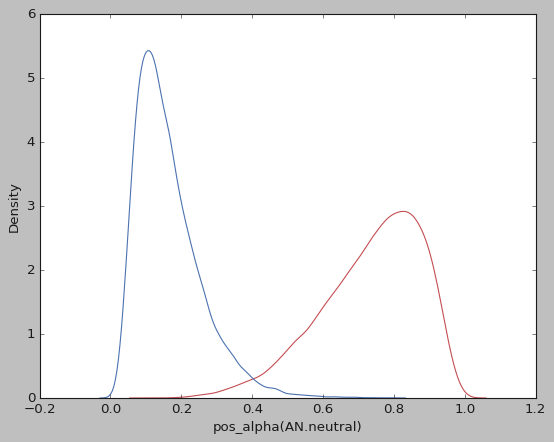

In [125]:
pos_alpha_n = np.exp(traces["pos_alpha(AN.neutral)"]) / (1 + np.exp(traces["pos_alpha(AN.neutral)"]))
pos_alpha_f = np.exp(traces["pos_alpha(AN.food)"]) / (1 + np.exp(traces["pos_alpha(AN.food)"]))


sns.kdeplot(
    pos_alpha_n, color="r", label="neg_alpha: " + str(np.round(np.mean(pos_alpha_n), 3))
)
sns.kdeplot(
    pos_alpha_f, color="b", label="pos_alpha: " + str(np.round(np.mean(pos_alpha_f), 3))
)

In [ ]:
# alpha_an_f.trace()


In [129]:
def inv_logits(x):
    return np.exp(x) / (1 + np.exp(x))

In [150]:
traces["score_diff"] = traces["pos_alpha(AN.neutral)"] - traces["pos_alpha(AN.food)"] 
quantiles = traces['score_diff'].quantile([0.025, 0.50, 0.975])
quantiles

0.025    0.869577
0.500    2.938912
0.975    4.974624
Name: score_diff, dtype: float64

In [131]:
inv_logits(quantiles)

0.025    0.704658
0.500    0.949737
0.975    0.993136
Name: score_diff, dtype: float64

In [149]:
traces["score_diff"] = traces["alpha(AN.food)"] - traces["alpha(AN.neutral)"] 
quantiles = traces['score_diff'].quantile([0.025, 0.50, 0.975])
quantiles

0.025   -4.985792
0.500   -1.612381
0.975    1.478660
Name: score_diff, dtype: float64

In [42]:
# traces["score_diff"] = traces["a(AN.food)"] - traces["a(AN.neutral)"]
# traces["score_diff"] = traces["a(BN.food)"] - traces["a(BN.neutral)"]
# traces["score_diff"] = traces["a(HC.food)"] - traces["a(HC.neutral)"]
traces["score_diff"] = traces["a(RI.food)"] - traces["a(RI.neutral)"]

The following code creates a figure of the posterior density plot of the difference between the parameters estimated in two conditions.


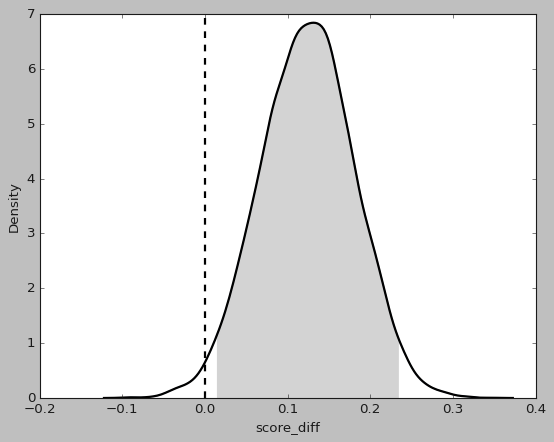

In [43]:
quantiles = traces['score_diff'].quantile([0.025, 0.975])

# Define delta lower and upper limits
low, high = quantiles[0.025], quantiles[0.975]

sns_plot = sns.kdeplot(data=traces, x="score_diff")

line = sns_plot.lines[0]
x, y = line.get_data()

plt.plot(x, y, color='black', lw=2)

idx_delta = np.logical_and(x >= low, x <= high)

plt.fill_between(x, y, where=idx_delta, color='lightgray')

plt.axvline(0, color='black', linestyle='--', linewidth=2)

sns_plot.figure.savefig("output.pdf")


In [44]:
# get model traces
grptrcs = mod1.get_group_traces()  # traces of all stochastic group nodes
alltrcs = mod1.get_traces()  # traces of all stochastic nodes


In [45]:
# export traces to .csv files (for later use in R)
grptrcs.to_csv('ddm/ddm_grptrcs.csv')
alltrcs.to_csv('ddm/ddm_alltrcs.csv')


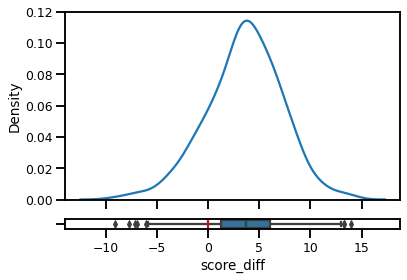

In [114]:
# # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
# f, (ax_kdeplot, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.95, .05)})

# # assigning a graph to each ax

# sns.kdeplot(data=traces, x="score_diff", ax=ax_kdeplot)
# plt.axvline(0, color='r')

# sns.boxplot(data=traces, x="score_diff", ax=ax_box)

# # Remove x axis name for the boxplot
# # ax_box.set(xlabel='')
# plt.show()

# # plt.savefig('plot_score_diff.pdf')


In [99]:
alpha_an_f,  alpha_an_n, alpha_bn_f,  alpha_bn_n, alpha_hc_f,  alpha_hc_n, alpha_ri_f,  alpha_ri_n = mod1.nodes_db.node[[
    'alpha(AN.food)',   'alpha(AN.neutral)',
    'alpha(BN.food)',   'alpha(BN.neutral)',
    'alpha(HC.food)',   'alpha(HC.neutral)',
    'alpha(RI.food)',   'alpha(RI.neutral)',
]]


In [100]:
pos_alpha_an_f,  pos_alpha_an_n, pos_alpha_bn_f,  pos_alpha_bn_n, pos_alpha_hc_f,  pos_alpha_hc_n, pos_alpha_ri_f,  pos_alpha_ri_n = mod1.nodes_db.node[[
    'pos_alpha(AN.food)',   'pos_alpha(AN.neutral)',
    'pos_alpha(BN.food)',   'pos_alpha(BN.neutral)',
    'pos_alpha(HC.food)',   'pos_alpha(HC.neutral)',
    'pos_alpha(RI.food)',   'pos_alpha(RI.neutral)',
]]


In [48]:
mod1.plot_posterior_predictive()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Alpha


Text(0.5, 1.0, 'Posterior of negative alpha group means')

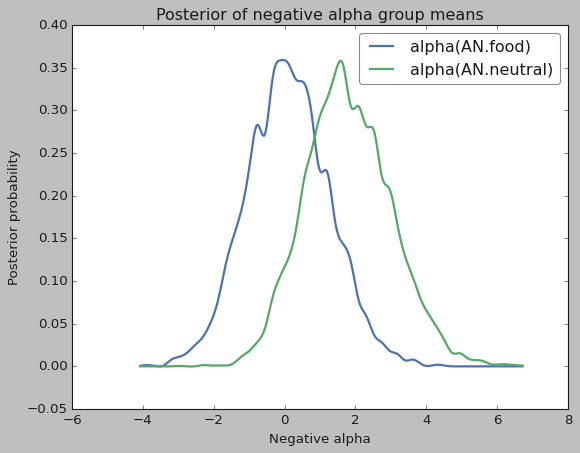

In [49]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_an_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')


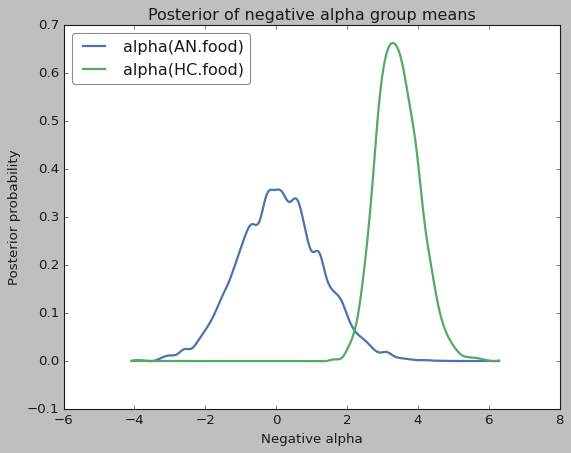

In [50]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_hc_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')
plt.savefig('negative_alpha_group_means.pdf', pad_inches=4.5)


Text(0.5, 1.0, 'Posterior of negative alpha group means')

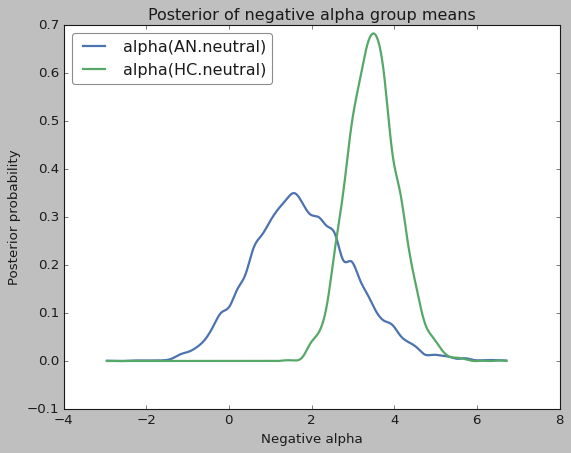

In [51]:
hddm.analyze.plot_posterior_nodes([alpha_an_n, alpha_hc_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')


Text(0.5, 1.0, 'Posterior of positive alpha group means')

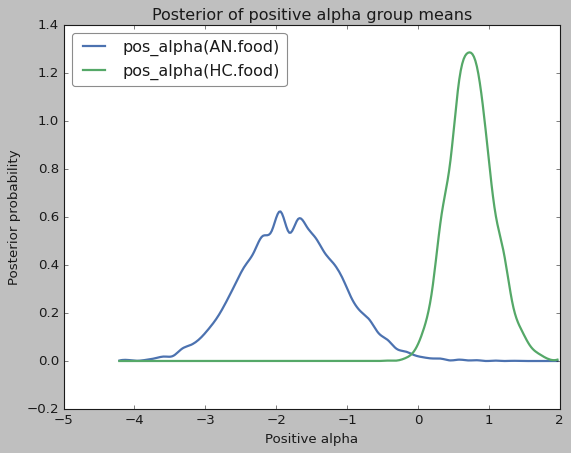

In [52]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_f, pos_alpha_hc_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')


Text(0.5, 1.0, 'Posterior of positive alpha group means')

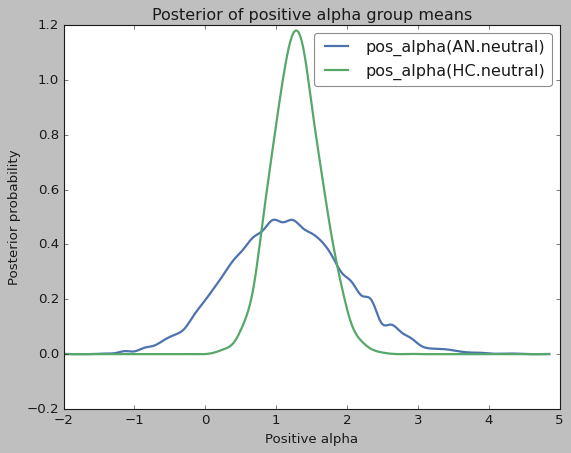

In [53]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_n, pos_alpha_hc_n])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')


In [111]:
print(
    "P(neg-alpha AN food > neg-alpha HC food) = ",
    (alpha_an_f.trace() > alpha_hc_f.trace()).mean(),
)
print(
    "P(neg-alpha AN neutral > neg-alpha HC neutral) = ",
    (alpha_an_n.trace() > alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha AN food > pos-alpha HC food) = ",
    (pos_alpha_an_f.trace() > pos_alpha_hc_f.trace()).mean(),
)
print(
    "P(pos-alpha AN neutral > pos-alpha HC neutral) = ",
    (pos_alpha_an_n.trace() > pos_alpha_hc_n.trace()).mean(),
)

P(neg-alpha AN food > neg-alpha HC food) =  0.0068
P(neg-alpha AN neutral > neg-alpha HC neutral) =  0.1044
P(pos-alpha AN food > pos-alpha HC food) =  0.001
P(pos-alpha AN neutral > pos-alpha HC neutral) =  0.4319


In [157]:
print("P(neg-alpha BN food < neg-alpha HC food) = ",
      (alpha_bn_f.trace() < alpha_hc_f.trace()).mean())
print("P(neg-alpha BN neutral < neg-alpha HC neutral) = ",
      (alpha_bn_n.trace() < alpha_hc_n.trace()).mean())
print("P(pos-alpha BN food < pos-alpha HC food) = ",
      (pos_alpha_bn_f.trace() < pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN neutral < pos-alpha HC neutral) = ",
      (pos_alpha_bn_n.trace() < pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN food < neg-alpha HC food) =  0.9489
P(neg-alpha BN neutral < neg-alpha HC neutral) =  0.8445
P(pos-alpha BN food < pos-alpha HC food) =  0.6279
P(pos-alpha BN neutral < pos-alpha HC neutral) =  0.6181


In [154]:
print(
    "P(neg-alpha HC food < neg-alpha HC neutral) = ",
    (alpha_hc_f.trace() < alpha_hc_n.trace()).mean(),
)
print(
    "P(neg-alpha AN food < neg-alpha AN neutral) = ",
    (alpha_an_f.trace() < alpha_an_n.trace()).mean(),
)
print(
    "P(neg-alpha BN food < neg-alpha BN neutral) = ",
    (alpha_bn_f.trace() < alpha_bn_n.trace()).mean(),
)
print(
    "P(neg-alpha RI food < neg-alpha RI neutral) = ",
    (alpha_ri_f.trace() < alpha_ri_n.trace()).mean(),
)
print(
    "P(pos-alpha HC food < pos-alpha HC neutral) = ",
    (pos_alpha_hc_f.trace() < pos_alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha AN food < pos-alpha AN neutral) = ",
    (pos_alpha_an_f.trace() < pos_alpha_an_n.trace()).mean(),
)
print(
    "P(pos-alpha BN food < pos-alpha BN neutral) = ",
    (pos_alpha_bn_f.trace() < pos_alpha_bn_n.trace()).mean(),
)
print(
    "P(pos-alpha RI food < pos-alpha RI neutral) = ",
    (pos_alpha_ri_f.trace() < pos_alpha_ri_n.trace()).mean(),
)

P(neg-alpha HC food < neg-alpha HC neutral) =  0.5303
P(neg-alpha AN food < neg-alpha AN neutral) =  0.8411
P(neg-alpha BN food < neg-alpha BN neutral) =  0.6767
P(neg-alpha RI food < neg-alpha RI neutral) =  0.2658
P(pos-alpha HC food < pos-alpha HC neutral) =  0.8945
P(pos-alpha AN food < pos-alpha AN neutral) =  0.9987
P(pos-alpha BN food < pos-alpha BN neutral) =  0.652
P(pos-alpha RI food < pos-alpha RI neutral) =  0.4808


In [158]:
print(
    "P(neg-alpha AN food < neg-alpha HC food) = ",
    (alpha_an_f.trace() < alpha_hc_f.trace()).mean(),
)
print(
    "P(neg-alpha AN neutral < neg-alpha HC neutral) = ",
    (alpha_an_n.trace() < alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha AN food < pos-alpha HC food) = ",
    (pos_alpha_an_f.trace() < pos_alpha_hc_f.trace()).mean(),
)
print(
    "P(pos-alpha AN neutral < pos-alpha HC neutral) = ",
    (pos_alpha_an_n.trace() < pos_alpha_hc_n.trace()).mean(),
)

P(neg-alpha AN food < neg-alpha HC food) =  0.9932
P(neg-alpha AN neutral < neg-alpha HC neutral) =  0.8956
P(pos-alpha AN food < pos-alpha HC food) =  0.999
P(pos-alpha AN neutral < pos-alpha HC neutral) =  0.5681


In [155]:
print(
    "P(neg-alpha BN food < neg-alpha HC food) = ",
    (alpha_bn_f.trace() < alpha_hc_f.trace()).mean(),
)
print(
    "P(neg-alpha BN neutral < neg-alpha HC neutral) = ",
    (alpha_bn_n.trace() < alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha BN food < pos-alpha HC food) = ",
    (pos_alpha_bn_f.trace() < pos_alpha_hc_f.trace()).mean(),
)
print(
    "P(pos-alpha BN neutral < pos-alpha HC neutral) = ",
    (pos_alpha_bn_n.trace() < pos_alpha_hc_n.trace()).mean(),
)

P(neg-alpha BN food < neg-alpha HC food) =  0.9489
P(neg-alpha BN neutral < neg-alpha HC neutral) =  0.8445
P(pos-alpha BN food < pos-alpha HC food) =  0.6279
P(pos-alpha BN neutral < pos-alpha HC neutral) =  0.6181


In [156]:
print(
    "P(neg-alpha RI food < neg-alpha HC food) = ",
    (alpha_ri_f.trace() < alpha_hc_f.trace()).mean(),
)
print(
    "P(neg-alpha RI neutral < neg-alpha HC neutral) = ",
    (alpha_ri_n.trace() < alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha RI food < pos-alpha HC food) = ",
    (pos_alpha_ri_f.trace() < pos_alpha_hc_f.trace()).mean(),
)
print(
    "P(pos-alpha RI neutral < pos-alpha HC neutral) = ",
    (pos_alpha_ri_n.trace() < pos_alpha_hc_n.trace()).mean(),
)

P(neg-alpha RI food < neg-alpha HC food) =  0.5606
P(neg-alpha RI neutral < neg-alpha HC neutral) =  0.8417
P(pos-alpha RI food < pos-alpha HC food) =  0.3281
P(pos-alpha RI neutral < pos-alpha HC neutral) =  0.6384


In [153]:
1 -  0.1589


0.8411

In [ ]:
# the plot shows that the model was able to recover the different decision threshold across groups.
a_group1, a_group2 = mod1.nodes_db.node[["a(group1)", "a(group2)"]]
hddm.analyze.plot_posterior_nodes([a_group1, a_group2])
plt.xlabel("decision threshold")
plt.ylabel("Posterior probability")
plt.xlim(0.7, 2.3)
plt.title("Posterior of decision threshold group means")

Text(0.5, 1.0, 'AN: Posterior of positive alpha condition means')

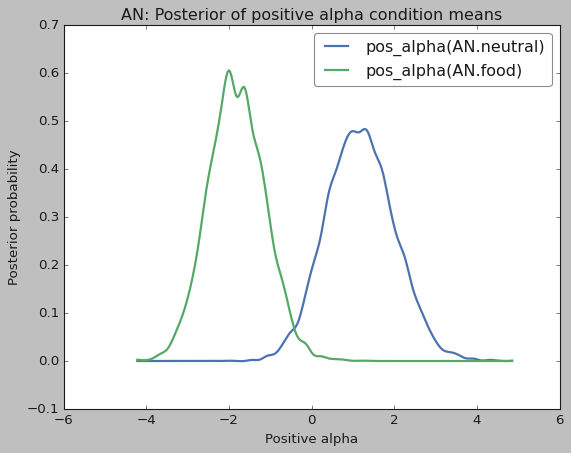

In [180]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_n, pos_alpha_an_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('AN: Posterior of positive alpha condition means')

Text(0.5, 1.0, 'AN: Posterior of negative alpha condition means')

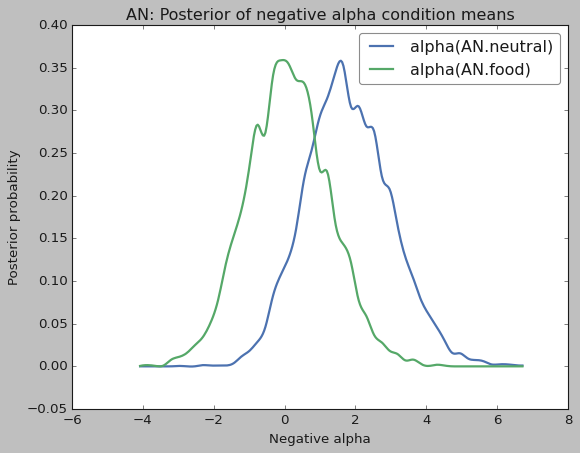

In [181]:
hddm.analyze.plot_posterior_nodes([alpha_an_n, alpha_an_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('AN: Posterior of negative alpha condition means')

# Drift rate


In [58]:
v_an_f,  v_an_n, v_bn_f,  v_bn_n, v_hc_f,  v_hc_n, v_ri_f,  v_ri_n = mod1.nodes_db.node[[
    'v(AN.food)',   'v(AN.neutral)',
    'v(BN.food)',   'v(BN.neutral)',
    'v(HC.food)',   'v(HC.neutral)',
    'v(RI.food)',   'v(RI.neutral)',
]]


In [59]:
print("P(v AN food > v HC food) = ", (v_an_f.trace() > v_hc_f.trace()).mean())
print("P(v AN neutral > v HC neutral) = ",
      (v_an_n.trace() > v_hc_n.trace()).mean())


P(v AN food > v HC food) =  0.5103
P(v AN neutral > v HC neutral) =  0.0507


In [60]:
print("P(v BN food > v HC food) = ", (v_bn_f.trace() > v_hc_f.trace()).mean())
print("P(v BN neutral > v HC neutral) = ",
      (v_bn_n.trace() > v_hc_n.trace()).mean())


P(v BN food > v HC food) =  0.3161
P(v BN neutral > v HC neutral) =  0.9042


In [61]:
print("P(v RI food > v HC food) = ", (v_ri_f.trace() > v_hc_f.trace()).mean())
print("P(v RI neutral > v HC neutral) = ",
      (v_ri_n.trace() > v_hc_n.trace()).mean())


P(v RI food > v HC food) =  0.1295
P(v RI neutral > v HC neutral) =  0.8912


In [62]:
print("P(v AN food < v AN neutral) = ", (v_an_f.trace() < v_an_n.trace()).mean())
print("P(v BN food < v BN neutral) = ", (v_bn_f.trace() < v_bn_n.trace()).mean())
print("P(v HC food < v HC neutral) = ", (v_hc_f.trace() < v_hc_n.trace()).mean())
print("P(v RI food < v RI neutral) = ", (v_ri_f.trace() < v_ri_n.trace()).mean())

P(v AN food < v AN neutral) =  0.1059
P(v BN food < v BN neutral) =  0.8952
P(v HC food < v HC neutral) =  0.4483
P(v RI food < v RI neutral) =  0.9617


# Decision threshold


In [108]:
a_an_f, a_an_n, a_bn_f, a_bn_n, a_hc_f, a_hc_n, a_ri_f, a_ri_n = mod1.nodes_db.node[
    [
        "a(AN.food)",
        "a(AN.neutral)",
        "a(BN.food)",
        "a(BN.neutral)",
        "a(HC.food)",
        "a(HC.neutral)",
        "a(RI.food)",
        "a(RI.neutral)",
    ]
]

In [109]:
print("P(a AN food < a AN neutral) = ", (a_an_f.trace() < a_an_n.trace()).mean())
print("P(a BN food < a BN neutral) = ", (a_bn_f.trace() < a_bn_n.trace()).mean())
print("P(a HC food < a HC neutral) = ", (a_hc_f.trace() < a_hc_n.trace()).mean())
print("P(a RI food < a RI neutral) = ", (a_ri_f.trace() < a_ri_n.trace()).mean())

P(a AN food < a AN neutral) =  0.0026
P(a BN food < a BN neutral) =  0.014
P(a HC food < a HC neutral) =  0.0002
P(a RI food < a RI neutral) =  0.0139


In [65]:
print("P(a AN food < a HC food) = ", (a_an_f.trace() < a_hc_f.trace()).mean())
print("P(a AN neutral < a HC neutral) = ", (a_an_n.trace() < a_hc_n.trace()).mean())


P(a AN food < a HC food) =  0.0357
P(a AN neutral < a HC neutral) =  0.4828


In [66]:
print("P(a BN food < a HC food) = ", (a_bn_f.trace() < a_hc_f.trace()).mean())
print("P(a BN neutral < a HC neutral) = ", (a_bn_n.trace() < a_hc_n.trace()).mean())


P(a BN food < a HC food) =  0.0746
P(a BN neutral < a HC neutral) =  0.6461


In [67]:
print("P(a RI food < a HC food) = ", (a_ri_f.trace() < a_hc_f.trace()).mean())
print("P(a RI neutral < a HC neutral) = ", (a_ri_n.trace() < a_hc_n.trace()).mean())

P(a RI food < a HC food) =  0.1252
P(a RI neutral < a HC neutral) =  0.436


# Non decision time


In [68]:
(t_an_f, t_an_n, t_bn_f, t_bn_n, t_hc_f, t_hc_n, t_ri_f, t_ri_n,) = mod1.nodes_db.node[
    [
        "t(AN.food)",
        "t(AN.neutral)",
        "t(BN.food)",
        "t(BN.neutral)",
        "t(HC.food)",
        "t(HC.neutral)",
        "t(RI.food)",
        "t(RI.neutral)",
    ]
]

In [69]:
print("P(t AN food < t HC food) = ", (t_an_f.trace() < t_hc_f.trace()).mean())
print("P(t AN neutral < t HC neutral) = ", (t_an_n.trace() < t_hc_n.trace()).mean())

P(t AN food < t HC food) =  0.4744
P(t AN neutral < t HC neutral) =  0.3131


In [70]:
print("P(t BN food < t HC food) = ", (t_bn_f.trace() < t_hc_f.trace()).mean())
print("P(t BN neutral < t HC neutral) = ", (t_bn_n.trace() < t_hc_n.trace()).mean())

P(t BN food < t HC food) =  0.6883
P(t BN neutral < t HC neutral) =  0.4639


In [71]:
print("P(t RI food < t HC food) = ", (t_ri_f.trace() < t_hc_f.trace()).mean())
print("P(t RI neutral < t HC neutral) = ", (t_ri_n.trace() < t_hc_n.trace()).mean())

P(t RI food < t HC food) =  0.3339
P(t RI neutral < t HC neutral) =  0.4501


In [72]:
print("P(t AN food < t AN neutral) = ", (t_an_f.trace() < t_an_n.trace()).mean())
print("P(t BN food < t BN neutral) = ", (t_bn_f.trace() < t_bn_n.trace()).mean())
print("P(t HC food < t HC neutral) = ", (t_hc_f.trace() < t_hc_n.trace()).mean())
print("P(t RI food < t RI neutral) = ", (t_ri_f.trace() < t_ri_n.trace()).mean())

P(t AN food < t AN neutral) =  0.824
P(t BN food < t BN neutral) =  0.7723
P(t HC food < t HC neutral) =  0.9413
P(t RI food < t RI neutral) =  0.6517


# Print fitted parameters and other model statistics


In [110]:
mod1.print_stats()


                                    mean       std       2.5q       25q       50q       75q      97.5q    mc err
a(AN.food)                      1.415473  0.038792   1.338847  1.389686  1.415784  1.441908   1.491058  0.000462
a(AN.neutral)                    1.25971  0.037977   1.186143  1.234392  1.259601  1.285442   1.334457  0.000435
a(BN.food)                      1.439834  0.065823   1.308936  1.395298  1.441424  1.484472   1.567022  0.000801
a(BN.neutral)                    1.22915  0.071689   1.085583  1.181153  1.230349  1.278117   1.368265  0.000671
a(HC.food)                      1.339932  0.015916   1.308528  1.329339   1.34004  1.350598   1.370901  0.000178
a(HC.neutral)                   1.257598  0.016515   1.225905  1.246365  1.257431  1.268563   1.290826  0.000185
a(RI.food)                      1.388596  0.039269   1.311919  1.362102  1.388923    1.4154   1.463125  0.000445
a(RI.neutral)                   1.264549  0.041682   1.182586  1.235972  1.264405  1.293466   1.

## Checking results


Plotting a(AN.food)
Plotting a(AN.neutral)
Plotting a(BN.food)
Plotting a(BN.neutral)
Plotting a(HC.food)
Plotting a(HC.neutral)
Plotting a(RI.food)
Plotting a(RI.neutral)
Plotting a_std
Plotting v(AN.food)
Plotting v(AN.neutral)
Plotting v(BN.food)
Plotting v(BN.neutral)
Plotting v(HC.food)
Plotting v(HC.neutral)
Plotting v(RI.food)
Plotting v(RI.neutral)
Plotting v_std
Plotting t(AN.food)
Plotting t(AN.neutral)
Plotting t(BN.food)
Plotting t(BN.neutral)


/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure(figsize=(10, 6))


Plotting t(HC.food)
Plotting t(HC.neutral)
Plotting t(RI.food)
Plotting t(RI.neutral)
Plotting t_std
Plotting alpha(AN.food)
Plotting alpha(AN.neutral)
Plotting alpha(BN.food)
Plotting alpha(BN.neutral)
Plotting alpha(HC.food)
Plotting alpha(HC.neutral)
Plotting alpha(RI.food)
Plotting alpha(RI.neutral)
Plotting alpha_std
Plotting pos_alpha(AN.food)
Plotting pos_alpha(AN.neutral)
Plotting pos_alpha(BN.food)
Plotting pos_alpha(BN.neutral)
Plotting pos_alpha(HC.food)
Plotting pos_alpha(HC.neutral)
Plotting pos_alpha(RI.food)
Plotting pos_alpha(RI.neutral)
Plotting pos_alpha_std


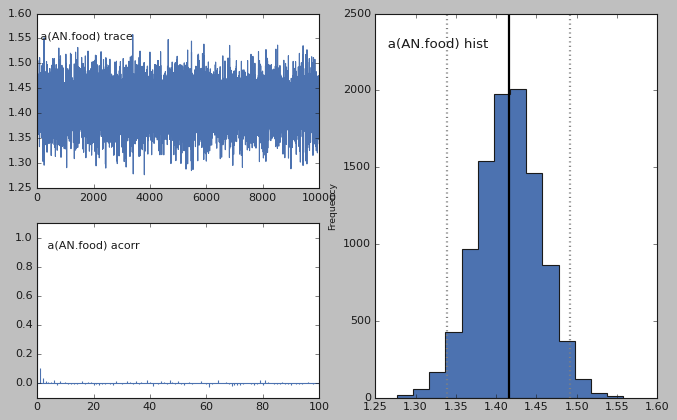

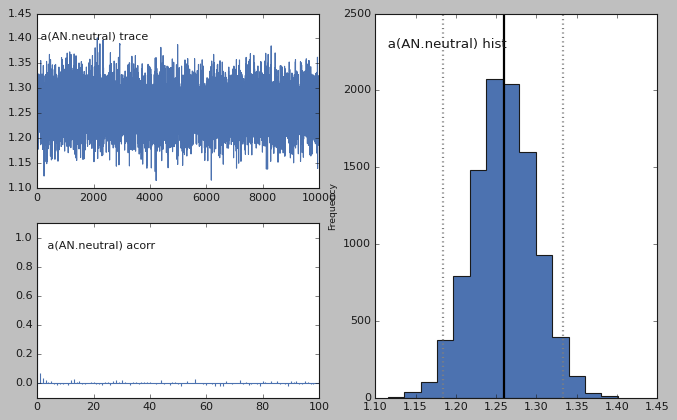

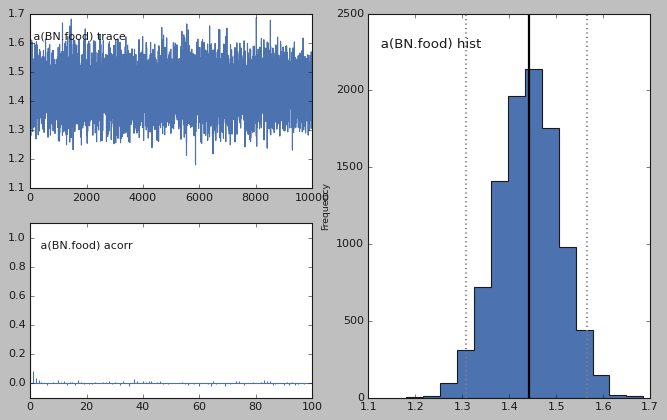

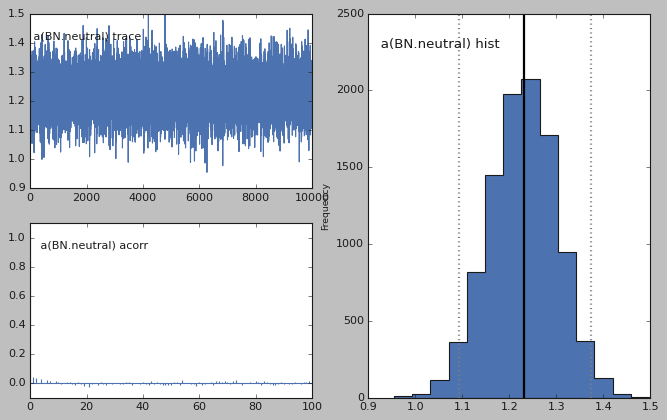

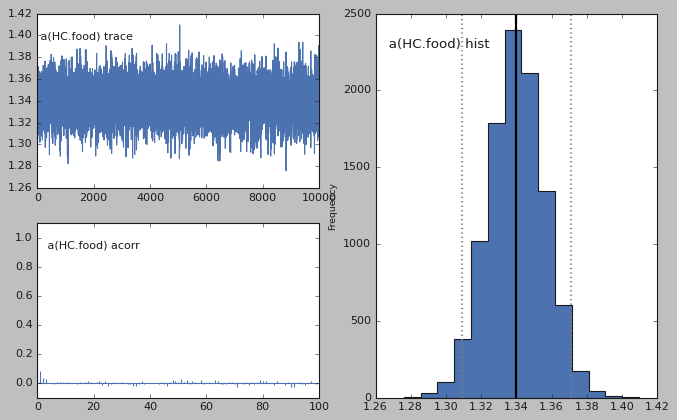

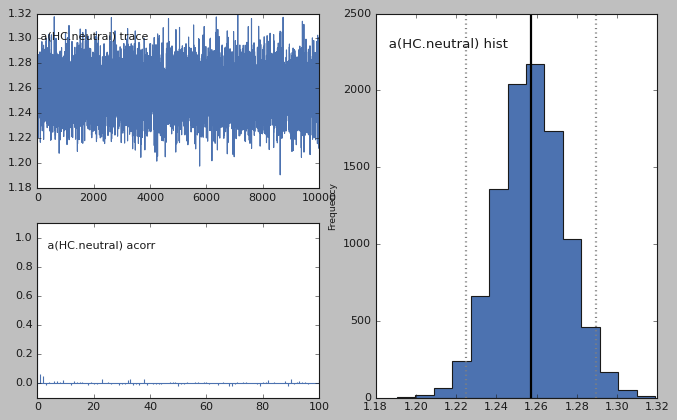

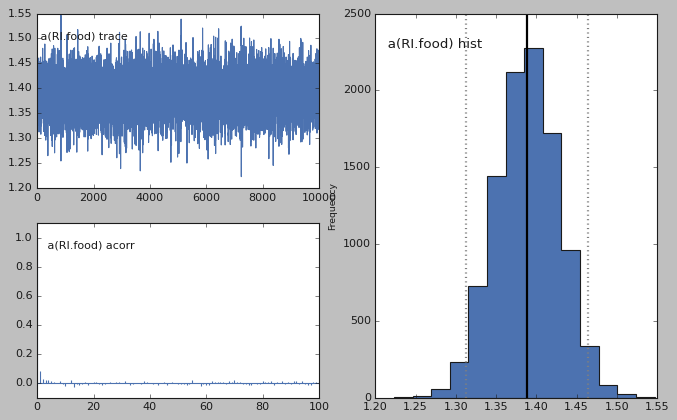

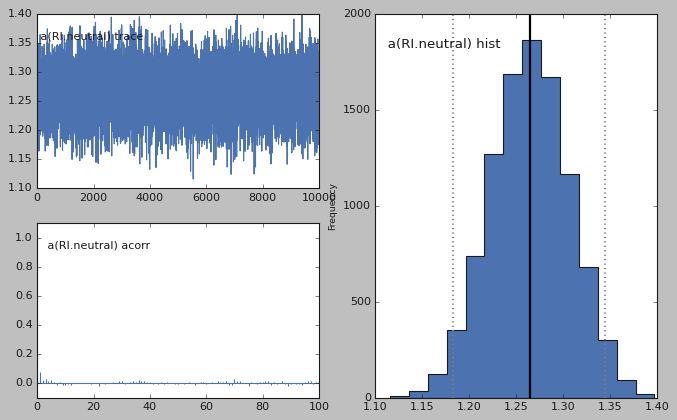

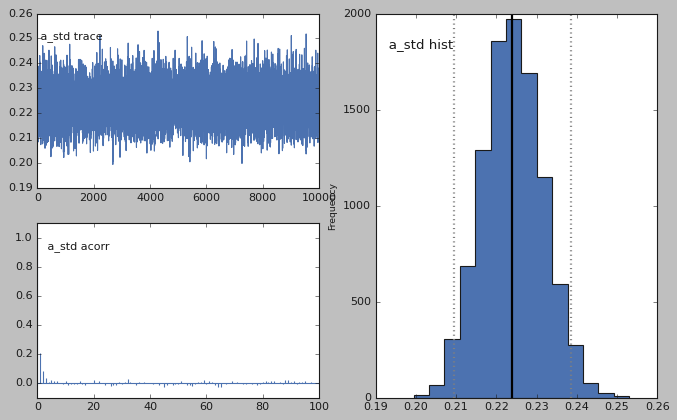

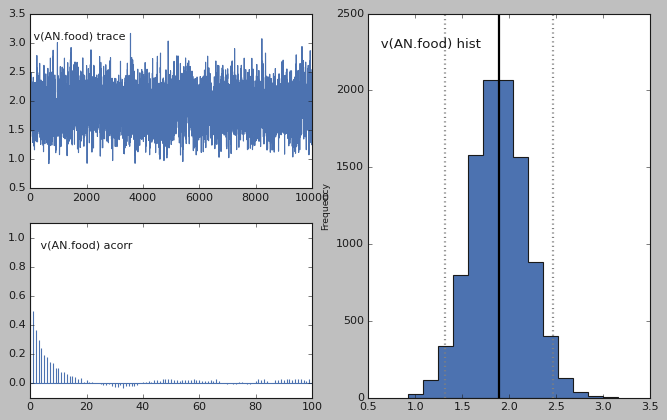

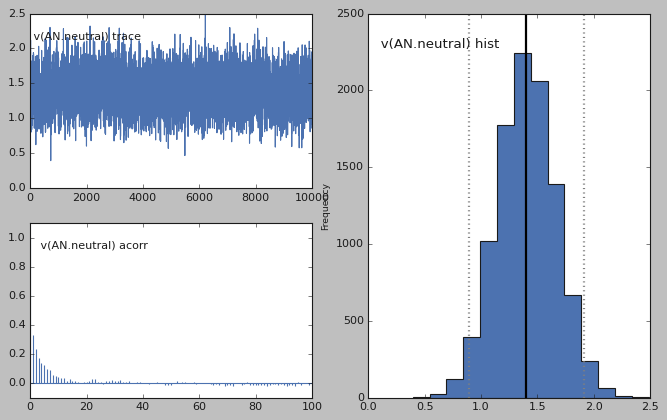

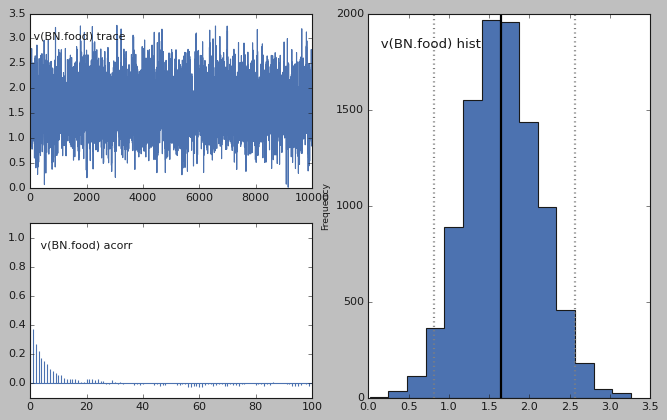

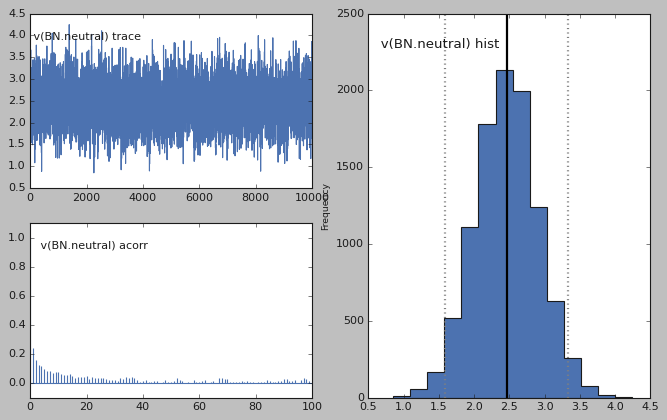

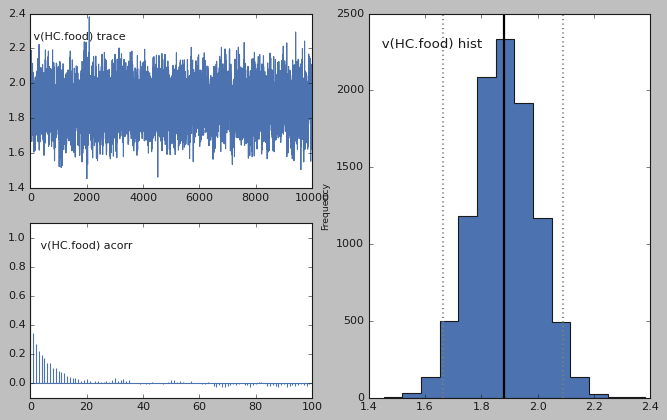

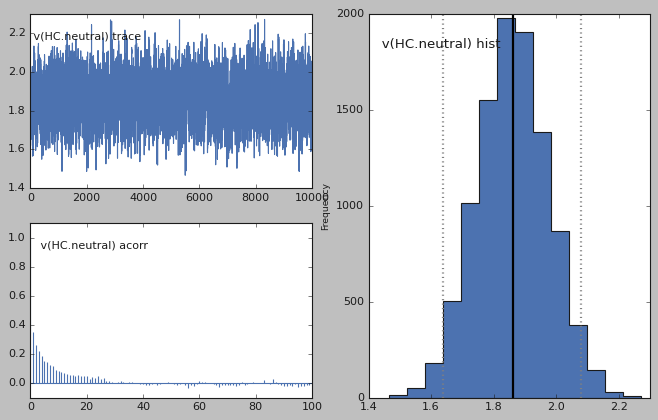

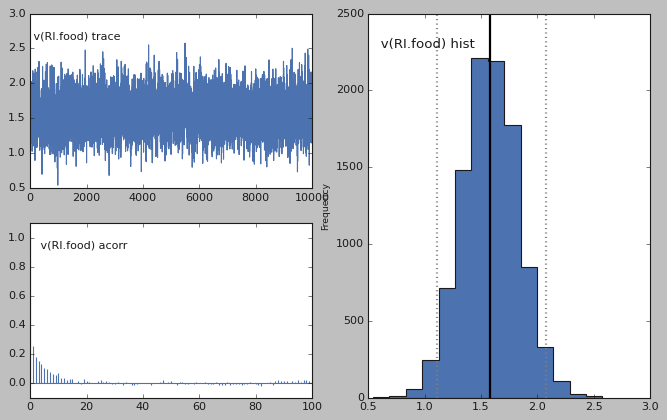

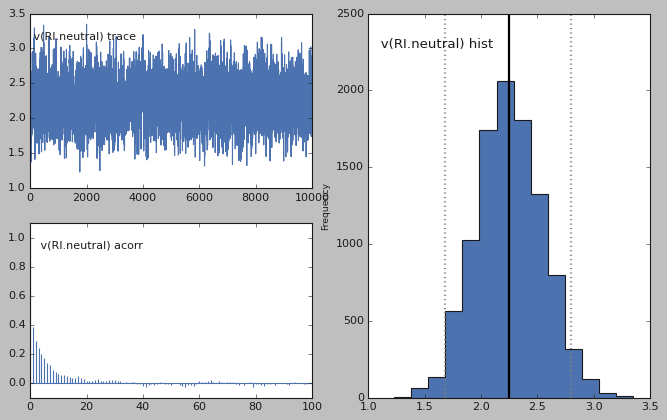

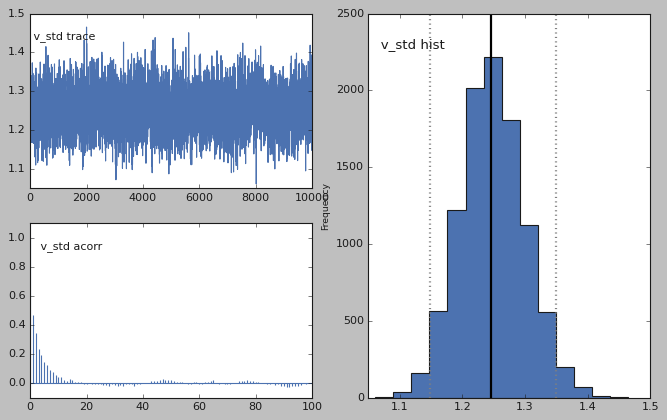

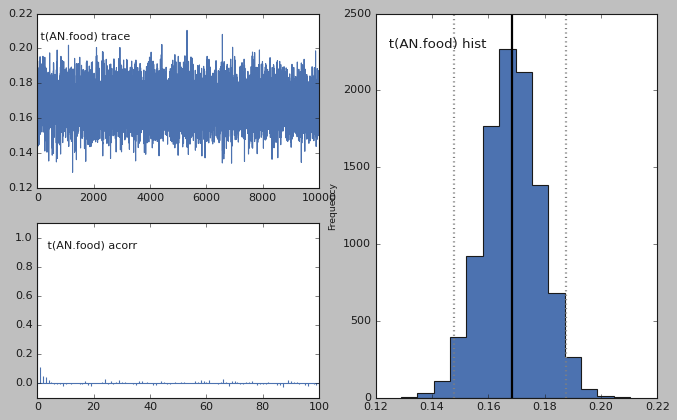

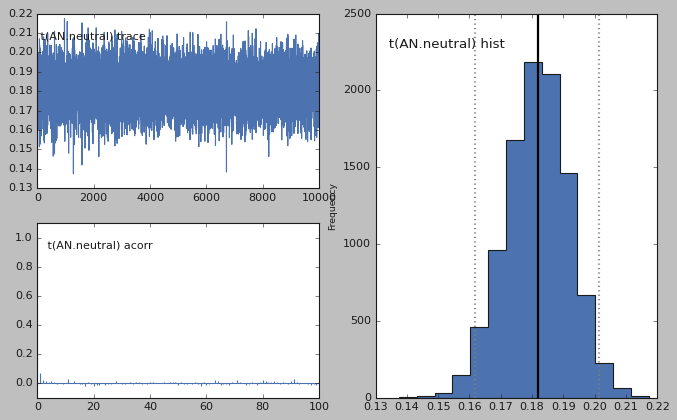

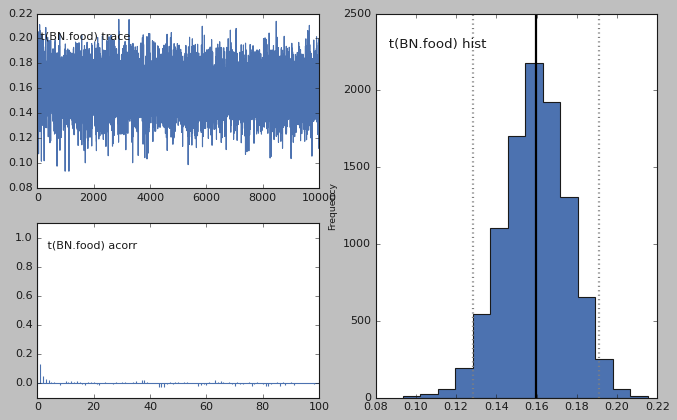

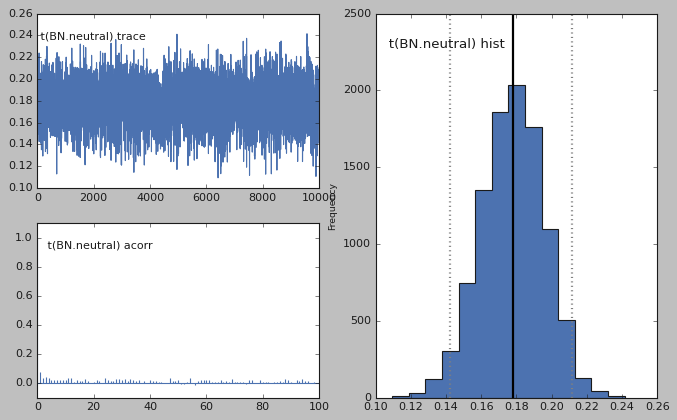

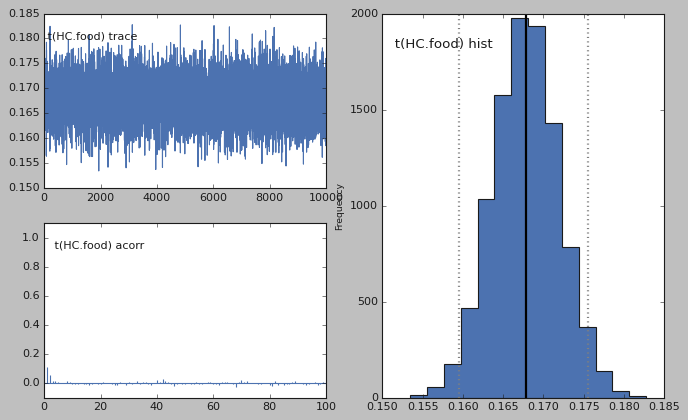

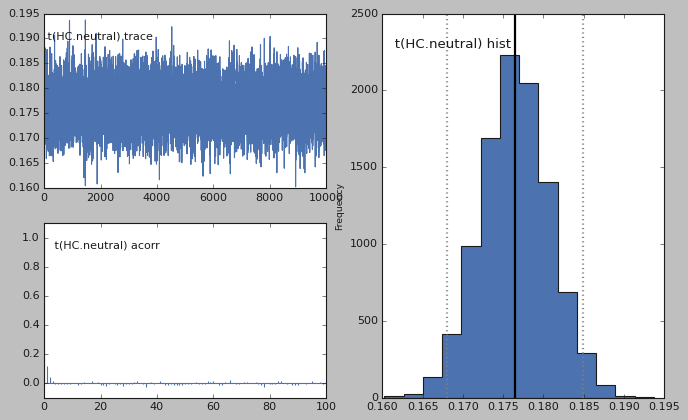

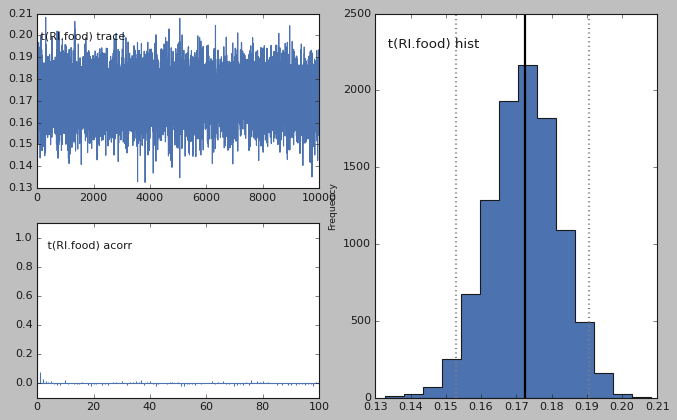

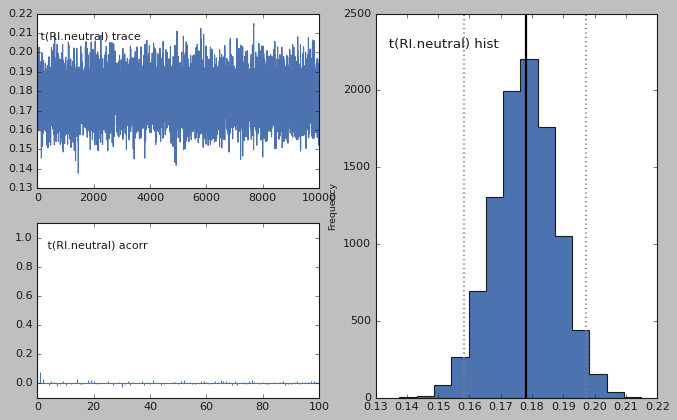

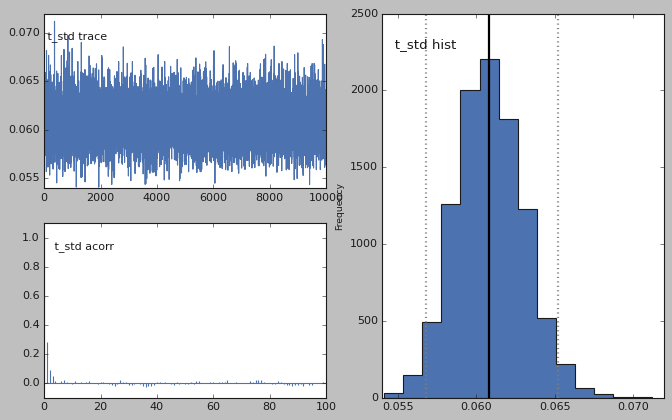

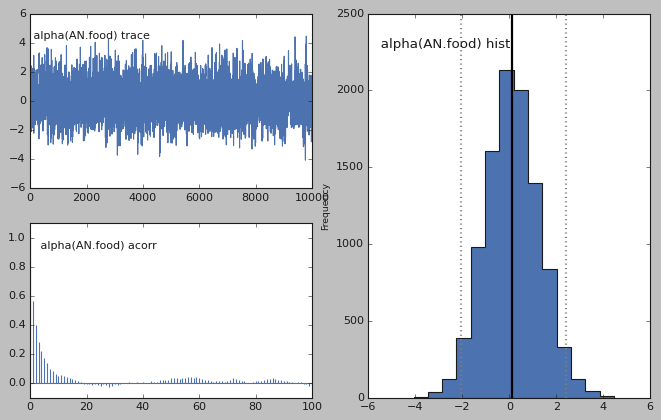

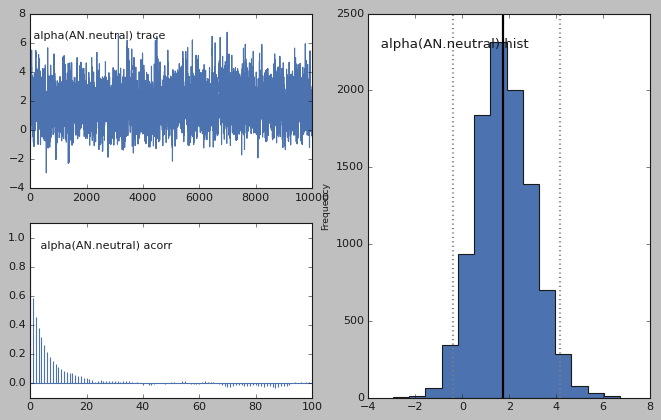

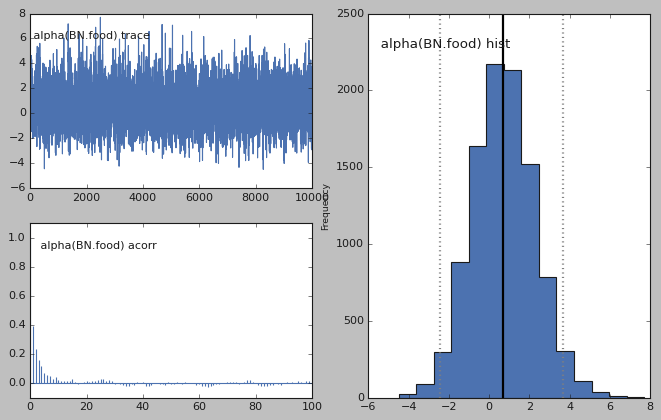

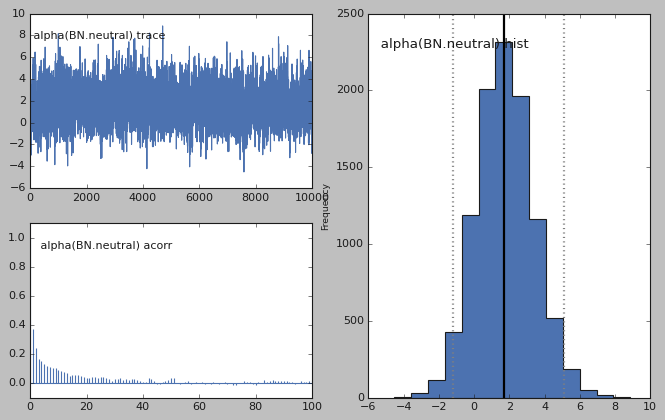

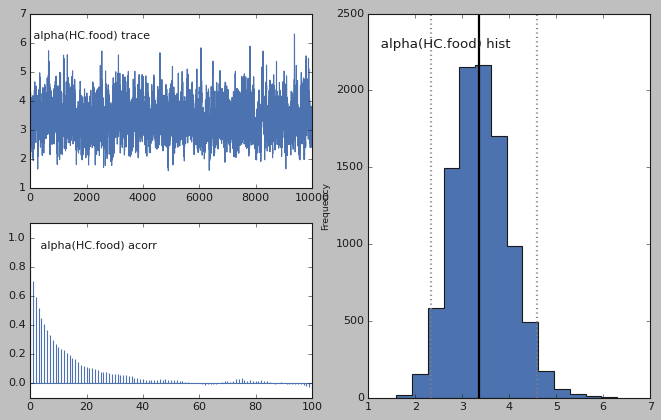

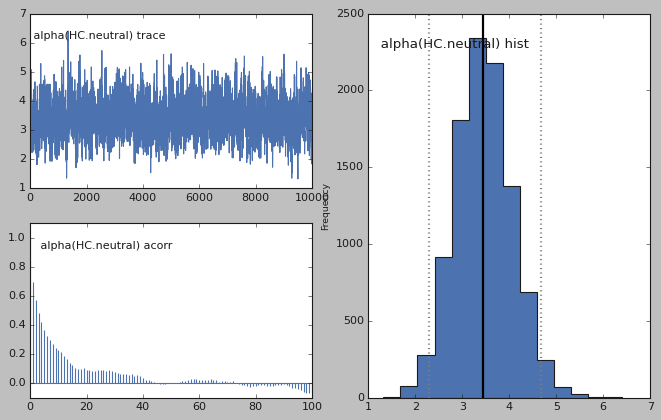

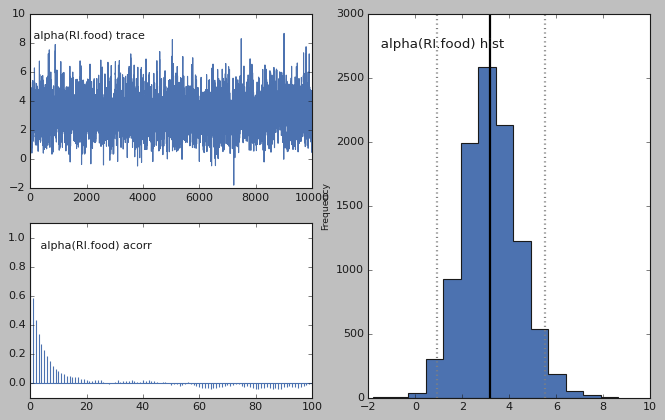

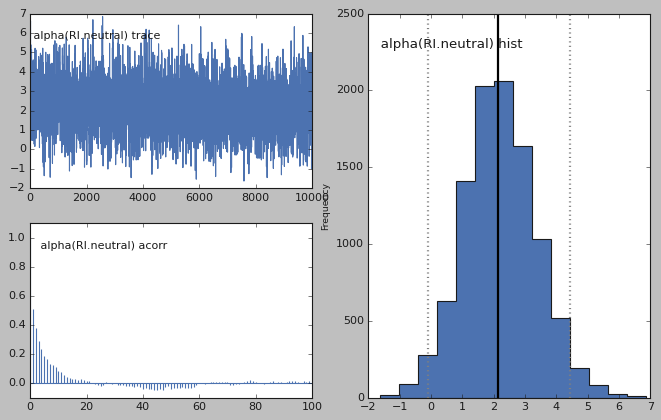

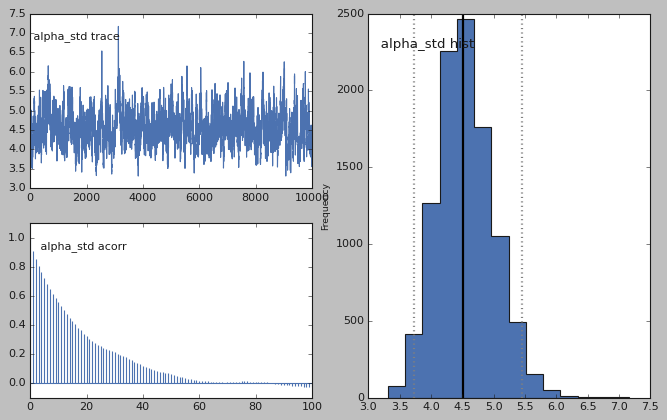

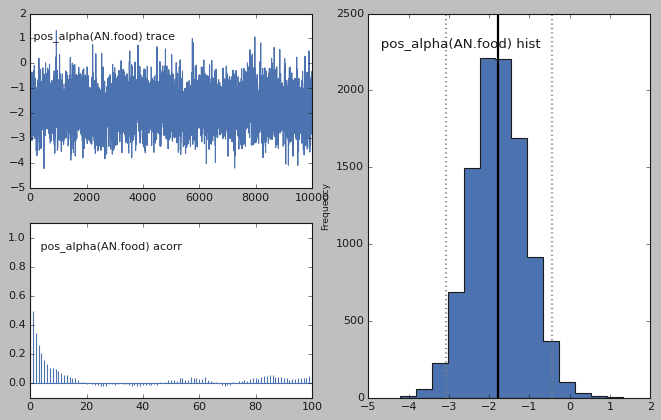

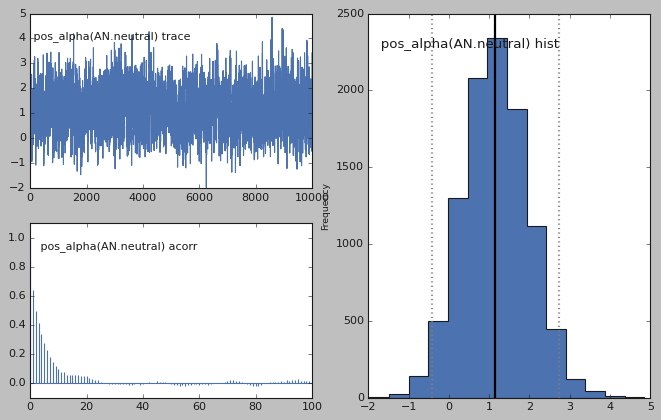

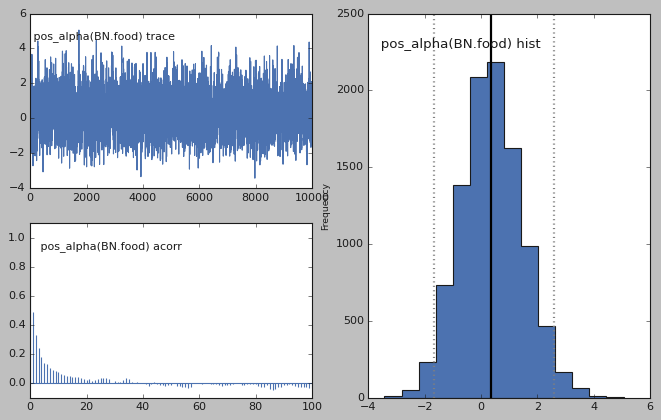

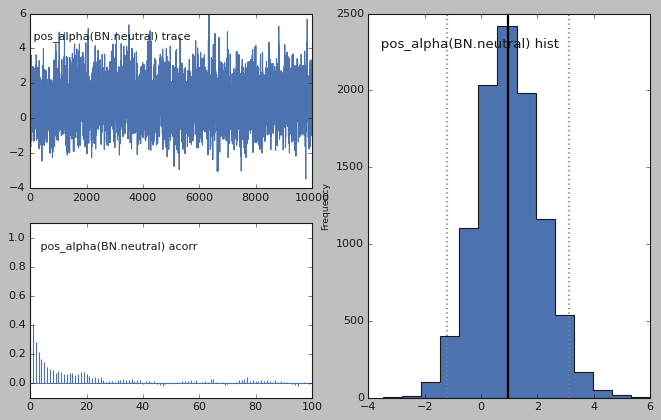

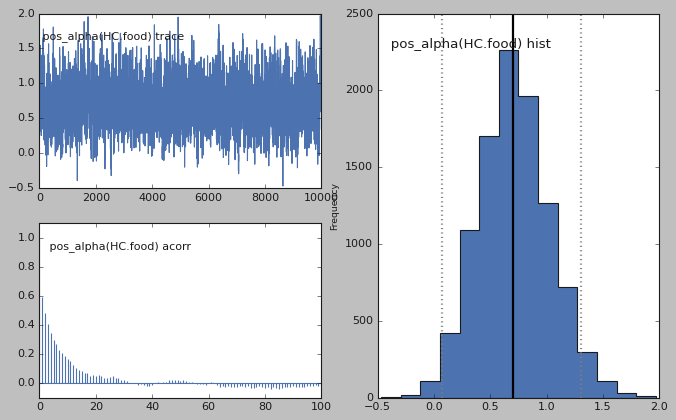

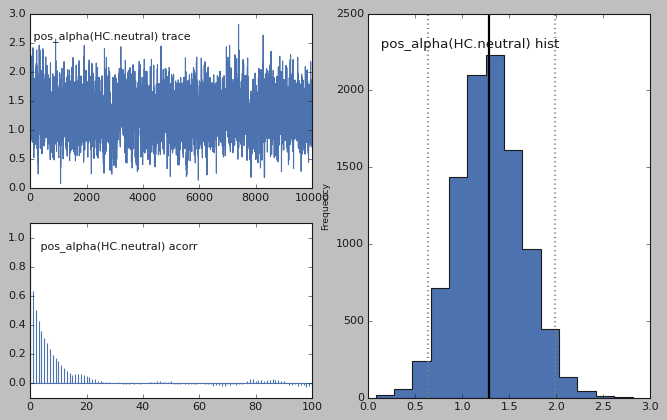

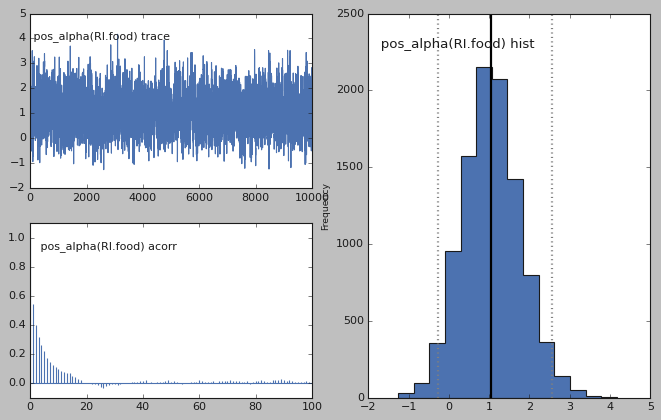

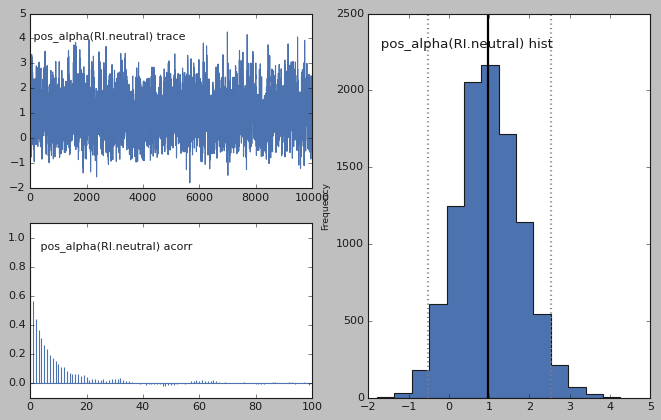

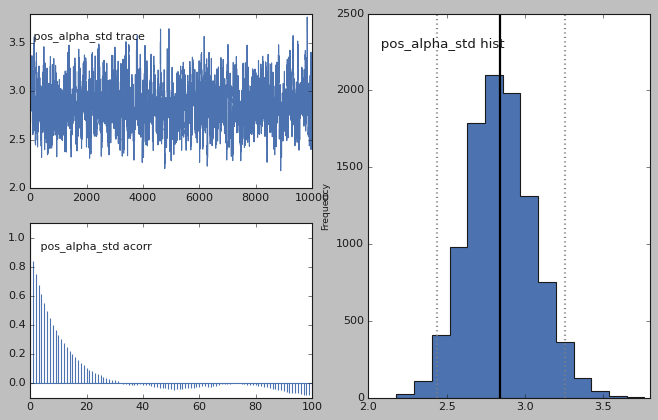

In [74]:
mod1.plot_posteriors()

### Estimate convergence


In [80]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        df,
        # bias=True,
        depends_on={
            'a': ['diag_cat', 'stim'],
            'v': ['diag_cat', 'stim'],
            't': ['diag_cat', 'stim'],
            'alpha': ['diag_cat', 'stim'],
            'pos_alpha': ['diag_cat', 'stim']
        },
        dual=True,  # separate learning rates for pos/neg feedbacks
        p_outlier=0.05,
        informative=True
    )
    m.sample(2000, burn=1000, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2001 of 2000 complete in 3855.0 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2001 of 2000 complete in 3697.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2001 of 2000 complete in 3980.5 sec

In [81]:
gel_rub = gelman_rubin(models)
str(gel_rub)

"{'a(AN.food)': 0.9999849456913603, 'a(AN.neutral)': 1.0004241672997611, 'a(BN.food)': 1.000399174602155, 'a(BN.neutral)': 0.9995573910711514, 'a(HC.food)': 1.0002595451363987, 'a(HC.neutral)': 1.00060900293982, 'a(RI.food)': 1.0019548850794917, 'a(RI.neutral)': 0.9999691119642453, 'a_std': 1.0012030138631485, 'a_subj(AN.food).1': 1.0025574140135305, 'a_subj(AN.food).6': 1.0010793131536035, 'a_subj(AN.food).7': 1.0021691318298838, 'a_subj(AN.food).9': 0.9998636186960108, 'a_subj(AN.food).10': 0.9995654097740448, 'a_subj(AN.food).11': 1.0001133940654419, 'a_subj(AN.food).12': 0.9995853146443462, 'a_subj(AN.food).13': 0.9999986089403702, 'a_subj(AN.food).18': 1.001820943811596, 'a_subj(AN.food).19': 1.0015767981588397, 'a_subj(AN.food).20': 1.0033193576191013, 'a_subj(AN.food).23': 1.0034323273467523, 'a_subj(AN.food).24': 1.0004417937216328, 'a_subj(AN.food).25': 1.0009997052141, 'a_subj(AN.food).26': 1.0051842882869293, 'a_subj(AN.food).28': 0.9999935729963046, 'a_subj(AN.food).29': 1.

In [82]:
np.max(list(gelman_rubin(models).values()))


1.0621460433018537

In [83]:
np.mean(list(gelman_rubin(models).values()))


1.0019492901157456

In [84]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(models)


Another test of the model is to look at collinearity. If the estimation of parameters is very codependent (correlation is strong) it can indicate that their variance trades off, in particular if there is a negative correlation. The following plot shows there is generally low correlation across all combinations of parameters. It does not seem to be the case for this dataset, but common for RLDDM is a negative correlation between learning rate and the scaling factor, similar to what’s usually observed between learning rate and inverse temperature for RL models that uses softmax as the choice rule (e.g. Daw, 2011).


In [85]:
alpha_an_f, alpha_an_n, alpha_hc_f, alpha_hc_n, pos_alpha_an_f, pos_alpha_an_n, pos_alpha_hc_f, pos_alpha_hc_n, t_an_f, t_an_n, t_hc_f, t_hc_n, a_an_f, a_an_n, a_hc_f, a_hc_n, v_an_f, v_an_n, v_hc_f, v_hc_n = m.nodes_db.node[[
    'alpha(AN.food)', 'alpha(AN.neutral)', 'alpha(HC.food)', 'alpha(HC.neutral)',
    'pos_alpha(AN.food)', 'pos_alpha(AN.neutral)', 'pos_alpha(HC.food)', 'pos_alpha(HC.neutral)',
    't(AN.food)', 't(AN.neutral)', 't(HC.food)', 't(HC.neutral)',
    'a(AN.food)', 'a(AN.neutral)', 'a(HC.food)', 'a(HC.neutral)',
    'v(AN.food)', 'v(AN.neutral)', 'v(HC.food)', 'v(HC.neutral)'
]]


In [86]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'alpha(HC.food)': alpha_hc_f.trace(),
    'alpha(HC.neutral)': alpha_hc_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    'pos_alpha(HC.food)': pos_alpha_hc_f.trace(),
    'pos_alpha(HC.neutral)': pos_alpha_hc_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    't(HC.food)': t_hc_f.trace(),
    't(HC.neutral)': t_hc_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'a(HC.food)': a_hc_f.trace(),
    'a(HC.neutral)': a_hc_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace(),
    'v(HC.food)': v_hc_f.trace(),
    'v(HC.neutral)': v_hc_n.trace()
}


In [87]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace()
}


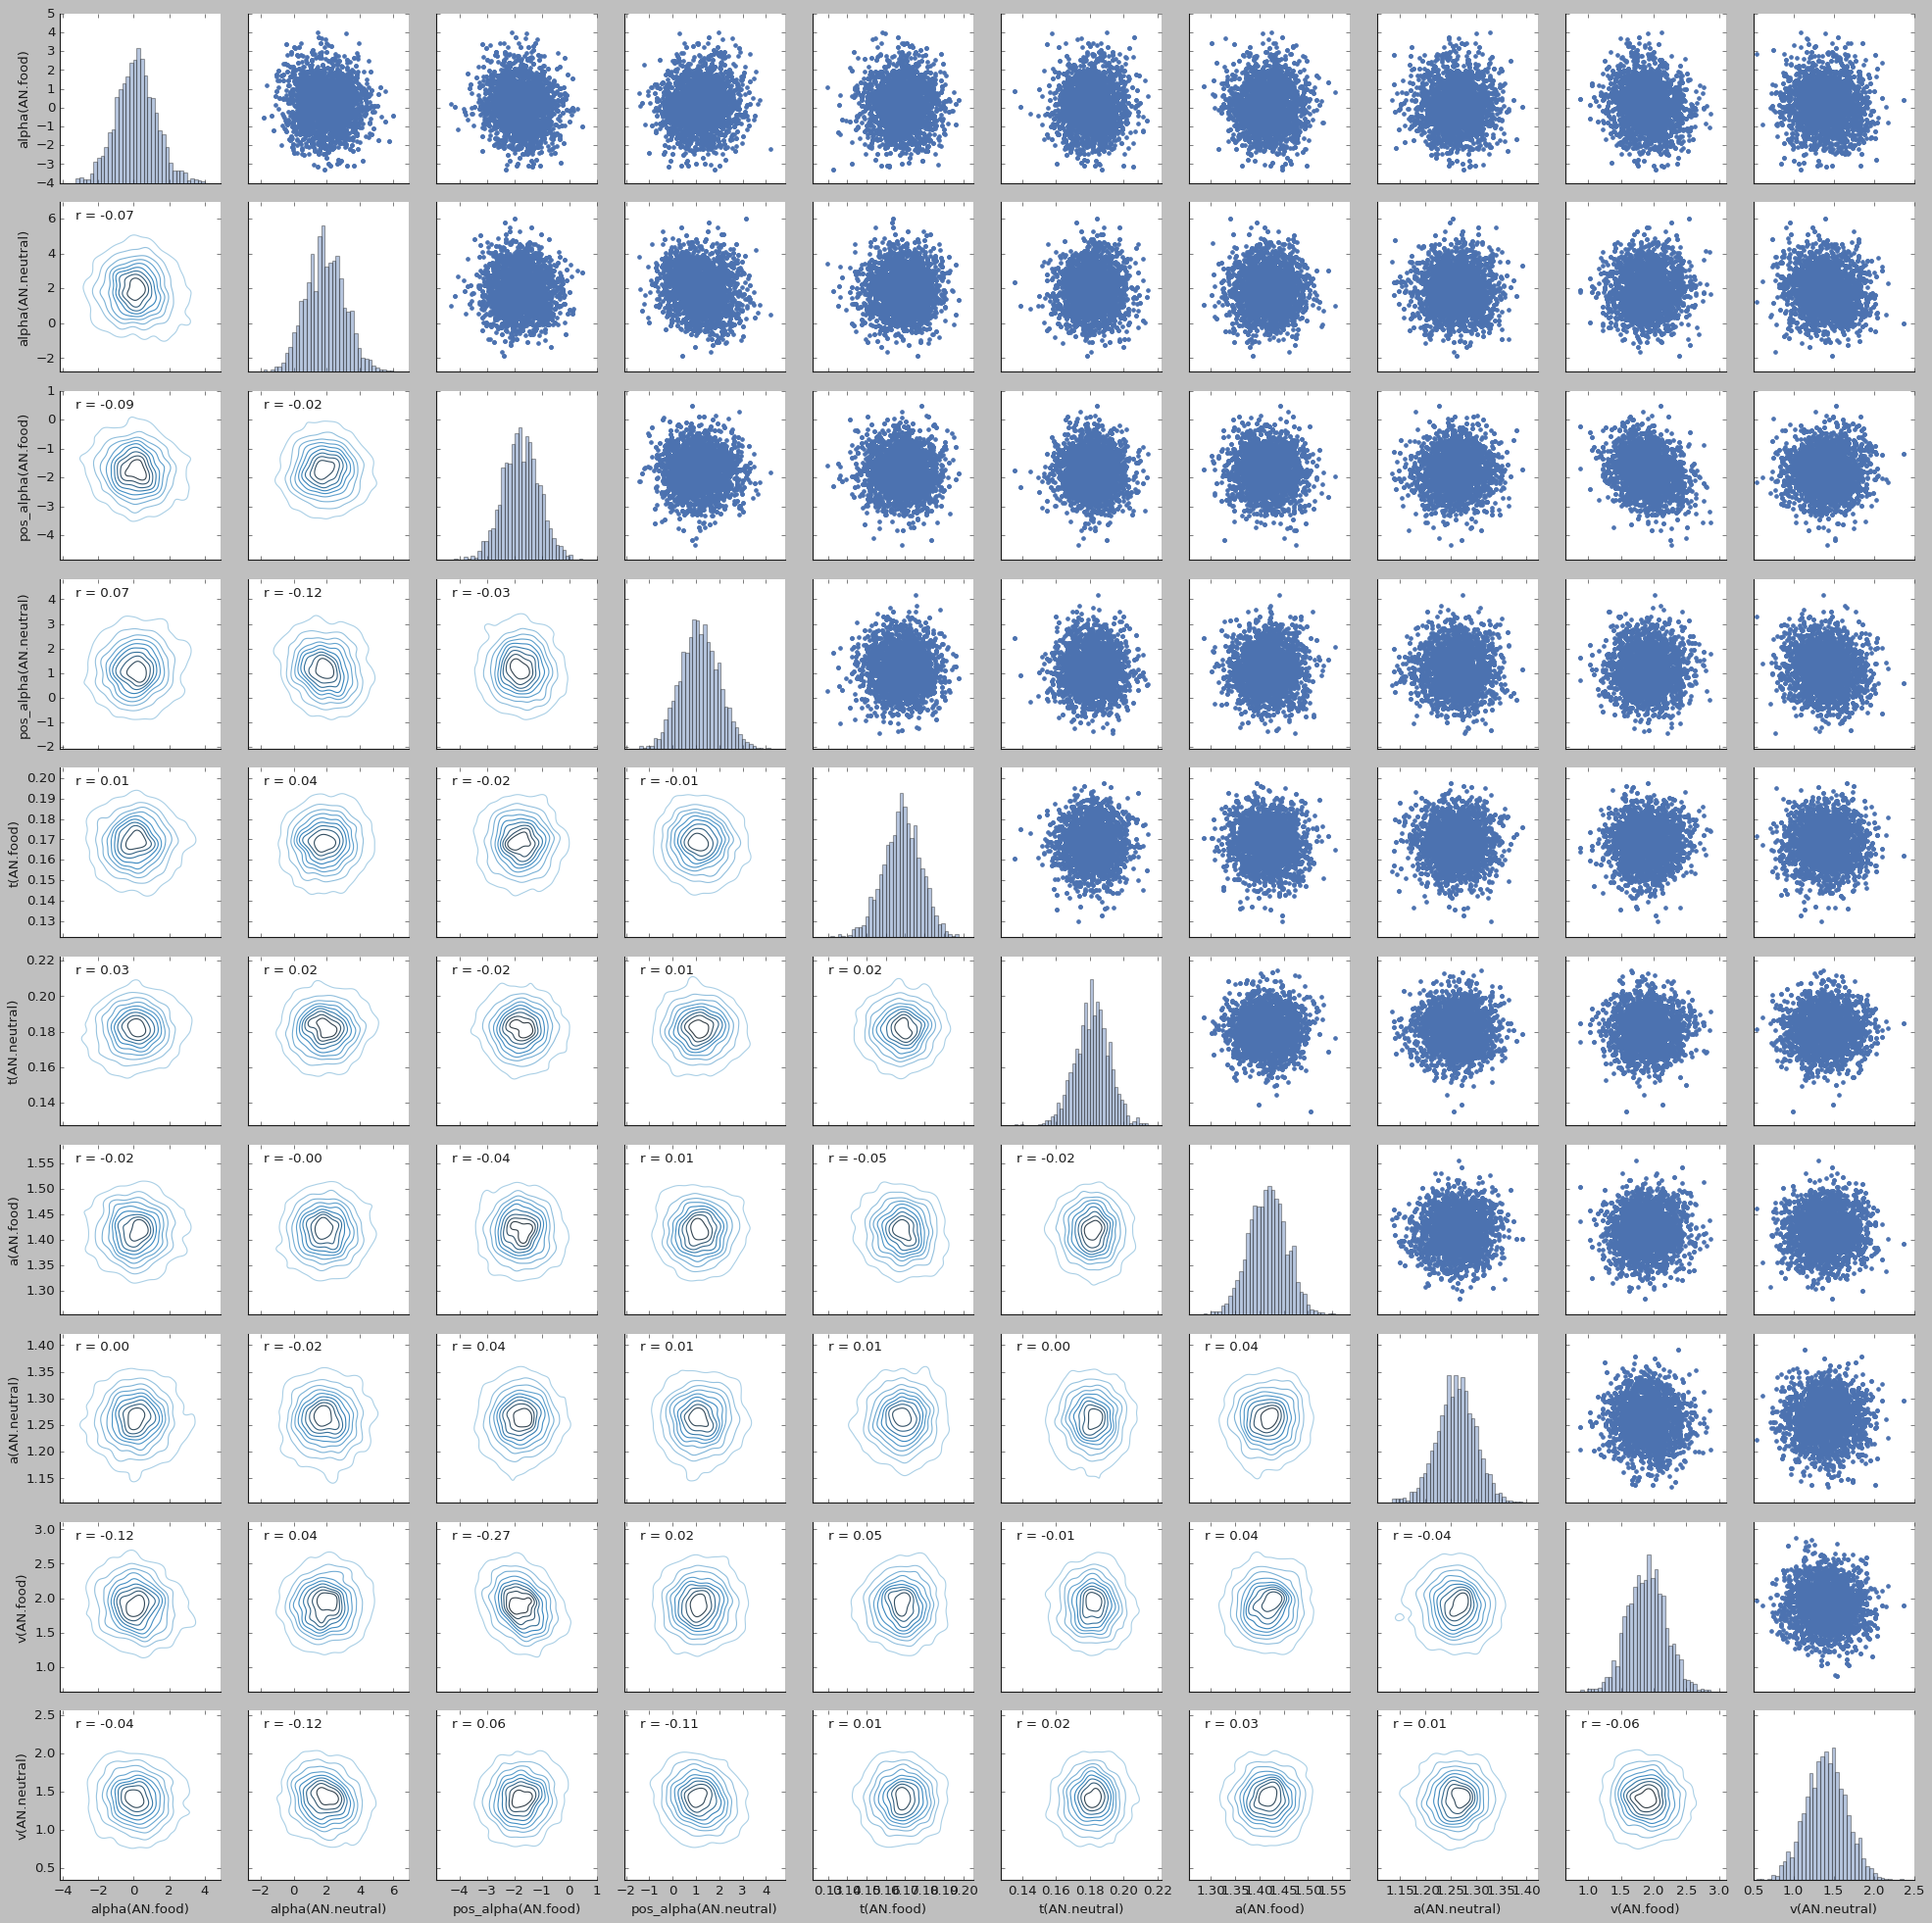

In [88]:
samp = pd.DataFrame(data=samples)


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')


## Posterior predictive checks


An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).


#### AN food


In [89]:
temp = df[
    (df.subj_code == "am_gu_1999_02_11_937_f") |  # AN
    (df.subj_code == "an_de_1998_11_10_289_f") |  # AN
    (df.subj_code == "gi_lo_2001_06_20_106_f") |  # HC
    (df.subj_code == "bi_ra_2000_09_28_341_f")   # HC
]

d = temp[(df.diag_cat == "AN")]
d.shape


(640, 10)

In [90]:
d = df

In [91]:
# Change subj_idx
d.loc[d.subj_code == "am_gu_1999_02_11_937_f", "subj_idx"] = 0
d.loc[d.subj_code == "an_de_1998_11_10_289_f", "subj_idx"] = 1

d.tail()


subj_idx  response     stim     rt  trial  split_by  feedback diag_cat  \
88795       296         1  neutral  0.400    158         1         1       HC   
88796       296         1     food  0.301    159         0         1       HC   
88797       296         1  neutral  0.680    159         1         1       HC   
88798       296         0     food  1.540    160         0         0       HC   
88799       296         1  neutral  0.404    160         1         1       HC   

                    subj_code  q_init  
88795  sa_li_2001_12_08_953_f     0.5  
88796  sa_li_2001_12_08_953_f     0.5  
88797  sa_li_2001_12_08_953_f     0.5  
88798  sa_li_2001_12_08_953_f     0.5  
88799  sa_li_2001_12_08_953_f     0.5

In [92]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        d,
        # bias=True,
        p_outlier=0.05
    )
    m.sample(600, burn=100, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 630.0 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 622.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 641.6 sec

In [93]:
# Combine the models
# m = kabuki.utils.concat_models(models)
traces = m.get_traces()
traces.head()


a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  1.342693  0.197000  1.426719  1.265811  1.002954  1.187936  1.567835   
1  1.343371  0.208922  1.428935  1.248220  1.027424  1.195904  1.637232   
2  1.324697  0.205011  1.407636  1.222856  1.026451  1.211113  1.618541   
3  1.332378  0.210810  1.396040  1.218469  1.038282  1.219874  1.602944   
4  1.315402  0.198989  1.411864  1.222869  1.033338  1.282716  1.577413   

   a_subj.5  a_subj.6  a_subj.7  ...  alpha_subj.287  alpha_subj.288  \
0  1.197702  1.234081  1.515137  ...        1.358207        1.519931   
1  1.158127  1.191192  1.484181  ...        3.985446        3.067642   
2  1.131670  1.216322  1.464456  ...       -0.599687        2.637231   
3  1.096325  1.268252  1.475259  ...       -0.629120        3.197270   
4  1.244794  1.317999  1.453096  ...        2.979089        0.761804   

   alpha_subj.289  alpha_subj.290  alpha_subj.291  alpha_subj.292  \
0       -0.910810        3.332573        2.902613        1.605221   
1       -1.557369        2.652333        5.195278        1.154009   
2       -1.152954        3.069277        4.669145        1.503783   
3       -0.194945        5.717724        4.293411        1.119735   
4       -0.156471        3.853051        3.838629        0.784427   

   alpha_subj.293  alpha_subj.294  alpha_subj.295  alpha_subj.296  
0        1.721420        0.865573        3.243617        0.360244  
1        1.755176        3.817586        4.275380        0.213172  
2        2.097661        4.523146        3.878464        0.577957  
3       -0.090041        4.588494        6.124043        4.508522  
4        2.501442        1.780807        4.524428        1.858186  

[5 rows x 1188 columns]

Now that we have the traces the next step is to simulate data using the estimated parameters.

Inputs to function:

- a = decision threshold
- t = non-decision time
- alpha = learning rate pos*alpha = defaults to 0 -- if given it defines the learning rate for positive prediction errors. alpha then becomes the learning rate* for negative prediction errors.
- scaler = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate p_upper = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0
- p_lower = the probability of reward for the option represented by the lower boundary.
- subjs = number of subjects to simulate data for.
- split_by = define the condition which makes it easier to append data from different conditions.
- size = number of trials per subject.


In [94]:
df1 = hddm.generate.gen_rand_rlddm_data(
    a=1.4,
    t=0.3,
    alpha=0.5,
    scaler=2,
    p_upper=0.7,
    p_lower=0.3,
    subjs=2,
    split_by=0,
    size=10
)


In [95]:
print(df1)


       q_up     q_low  sim_drift  response        rt  feedback  subj_idx  \
0  0.500000  0.500000   0.000000       0.0  0.676186       1.0         0   
1  0.500000  0.771175  -0.557172       0.0  1.129186       1.0         0   
2  0.500000  0.895278  -0.812162       0.0  0.642186       0.0         0   
3  0.500000  0.409724   0.185487       1.0  0.680186       0.0         0   
4  0.228825  0.409724  -0.371685       0.0  0.492186       0.0         0   
5  0.228825  0.187510   0.084888       0.0  2.818186       0.0         0   
6  0.228825  0.085814   0.293838       1.0  0.573186       1.0         0   
7  0.647072  0.085814   1.153193       1.0  0.448186       0.0         0   
8  0.296132  0.085814   0.432132       0.0  0.573186       1.0         0   
9  0.296132  0.581623  -0.586586       1.0  0.591186       1.0         0   
0  0.500000  0.500000   0.000000       1.0  0.790101       1.0         1   
1  0.721419  0.500000   0.595255       1.0  1.116101       1.0         1   
2  0.844786 

In [96]:
from tqdm import tqdm  # progress tracker
# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
d['samp'] = 0
# load traces
traces = m.get_traces()


In [97]:
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 10)):
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0]-1)
    # loop through all subjects in observed data
    for s in d.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 0)].trial.unique())
        size1 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 1)].trial.unique())
        # size2 = len(d[(d['subj_idx']==s) & (d['split_by']==2)].trial.unique())
        # set parameter values for simulation
        a = traces.loc[sample, 'a_subj.'+str(s)]
        t = traces.loc[sample, 't_subj.'+str(s)]
        scaler = traces.loc[sample, 'v_subj.'+str(s)]
        alphaInv = traces.loc[sample, 'alpha_subj.'+str(s)]
        # #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        # #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size0, p_upper=0.7, p_lower=0.3, split_by=0)
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size1, p_upper=0.7, p_lower=0.3, split_by=1)
        # #sim_data2 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        # #append the conditions
        sim_data0 = sim_data0.append([sim_data1], ignore_index=True)
        # #assign subj_idx
        sim_data0['subj_idx'] = s
        # #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        # #identify the simulated data
        sim_data0['samp'] = i
        # #append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)


  0%|          | 0/9 [00:24<?, ?it/s]


KeyError: 0

In [227]:
# combine observed and simulated data
ppc_data = d[['subj_idx', 'response', 'split_by',
              'rt', 'trial', 'feedback', 'samp']].copy()
ppc_data['type'] = 'observed'
ppc_sdata = sim_data[['subj_idx', 'response', 'split_by',
                      'rt', 'trial', 'feedback', 'type', 'samp']].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv('ppc_data_tutorial.csv')


In [228]:
# for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_data = ppc_data[ppc_data.trial < 41].copy()

In [229]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data['bin_trial'] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)).astype('int64')
# calculate means for each sample
sums = plot_ppc_data.groupby(
    ['bin_trial', 'split_by', 'samp', 'type']).mean().reset_index()
# calculate the overall mean response across samples
ppc_sim = sums.groupby(['bin_trial', 'split_by', 'type']).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim['upper_hpd'] = 0
ppc_sim['lower_hpd'] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial'] == ppc_sim.bin_trial[i]) & (
        sums['split_by'] == ppc_sim.split_by[i]) & (sums['type'] == ppc_sim.type[i])], alpha=0.1)
    ppc_sim.loc[i, 'upper_hpd'] = hdi[1]
    ppc_sim.loc[i, 'lower_hpd'] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim['up_err'] = ppc_sim['upper_hpd']-ppc_sim['response']
ppc_sim['low_err'] = ppc_sim['response']-ppc_sim['lower_hpd']
ppc_sim['model'] = 'RLDDM_single_learning'
ppc_sim.to_csv('ppc_choicedata_tutorial.csv')


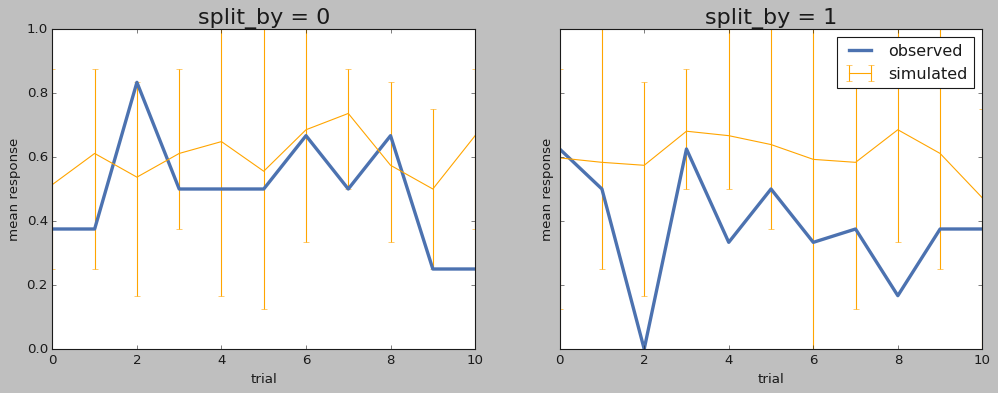

In [230]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1,
                        ncols=2, sharex=True, sharey=True)
for i in range(0, 2):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'simulated')]
    ax.errorbar(d.bin_trial, d.response, yerr=[
                d.low_err, d.up_err], label='simulated', color='orange')
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'observed')]
    ax.plot(d.bin_trial, d.response, linewidth=3, label='observed')
    ax.set_title('split_by = %i' % i, fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.legend()
fig.savefig('PPCchoice.pdf')


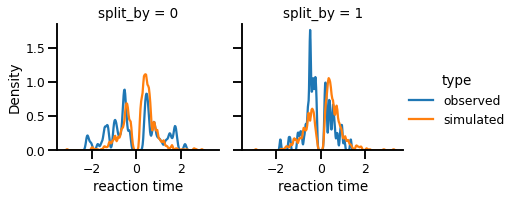

In [208]:
# set reaction time to be negative for lower bound responses (response=0)
plot_ppc_data['reaction time'] = np.where(
    plot_ppc_data['response'] == 1, plot_ppc_data.rt, 0-plot_ppc_data.rt)
# plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy.
g = sns.FacetGrid(plot_ppc_data, col='split_by', hue='type')
g.map(sns.kdeplot, 'reaction time', bw=0.05).set_ylabels("Density")
g.add_legend()
g.savefig('PPCrt_dist.pdf')


## Parameter recovery


In [21]:
param_recovery = hddm.load_csv('recovery_sim_est_rlddm.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'recovery_sim_est_rlddm.csv'